In [30]:
import zipfile
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from os.path import exists

In [31]:
# https://www.kaggle.com/balraj98/movie-genre-prediction-from-wiki-plot-using-bert
if not exists('wiki_movie_plots_deduped.csv'):
    with zipfile.ZipFile('wiki_movie_plots_deduped.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

# https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags
if not exists('mpst_full_data.csv'):
    with zipfile.ZipFile('mpst-movie-plot-synopses-with-tags.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
plots_mpst = pd.read_csv('mpst_full_data.csv')

In [32]:
print(plots_mpst.shape)
mpst = plots_mpst.drop(columns=['imdb_id', 'split','synopsis_source'])
mpst = mpst.rename(columns={'title':'Title', 'plot_synopsis': 'Plot','tags':'Genre'})
mpst.head()

(14828, 6)


,Title,Plot,Genre
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric"
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good"
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm..."


In [33]:
plots = pd.read_csv('wiki_movie_plots_deduped.csv')
wiki = plots.drop(columns=['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'])
wiki = wiki[['Title', 'Plot', 'Genre']]
print(wiki.shape)
wiki.head()

(34886, 3)


,Title,Plot,Genre
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr...",unknown
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov...",unknown
2,The Martyred Presidents,"The film, just over a minute long, is composed...",unknown
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...,unknown
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...,unknown


In [34]:
merged_dataset = pd.concat([mpst, wiki])
print(merged_dataset.shape)
merged_dataset.head()

(49714, 3)


,Title,Plot,Genre
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric"
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good"
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm..."


In [35]:
unique_genres_count = plots['Genre'].unique().shape[0]
print(f'Уникальных значений в поле жанр: {unique_genres_count}')

Уникальных значений в поле жанр: 2265


<AxesSubplot: title={'center': 'Количество релизов по годам'}, xlabel='Release Year'>

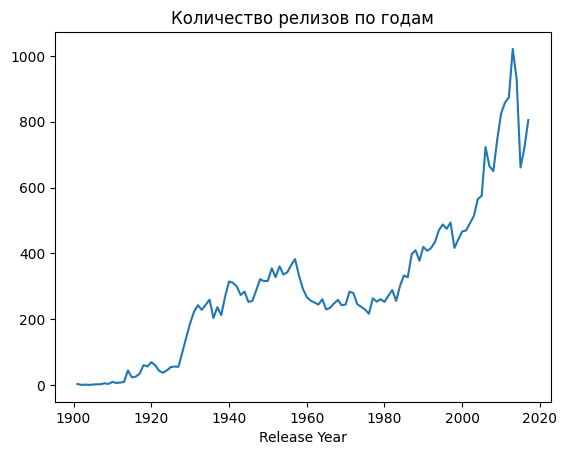

In [36]:
films_count_by_year = plots.groupby(['Release Year'])['Release Year'].count()
films_count_by_year.plot(title = 'Количество релизов по годам')

In [37]:
tokenizer = WordPunctTokenizer()
all_words = list()
for a, t in plots.iterrows():
    for cc in tokenizer.tokenize(t['Plot']):
        all_words.append(cc)
len_total_words_without_processing = len(all_words)
print(f'Общее количество уникальны слов без лемматизации и стемминга: {len_total_words_without_processing}')


Общее количество уникальны слов без лемматизации и стемминга: 15288663


In [38]:
# стемминг и лемматизация:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# set_stem_after_lem = set()
# set_lem_after_stem = set()
#
# lem = WordNetLemmatizer()
# stem = PorterStemmer()
#
# for a in tqdm(all_words):
#     w1 = stem.stem(lem.lemmatize(a))
#     set_stem_after_lem.add(w1)
#     w2 = lem.lemmatize(stem.stem(a))
#     set_lem_after_stem.add(w2)
#
# count_stem_after_lem = len(set_stem_after_lem)
# count_lem_after_stem = len(set_lem_after_stem)
# print(f'Уникальных слов (стемминг после лемматизации): {count_stem_after_lem}')
# print(f'Уникальных слов (лемматизация после стемминга: {count_lem_after_stem}')

In [39]:
def get_sentiment(obj: tuple):
    neg = obj['neg']
    neu = obj['neu']
    pos = obj['pos']
    if neg > neu:
        if neg > pos:
            return 'neg'
        else:
            return 'pos'
    else:
        if neu > pos:
            return 'neu'
        else:
            return 'pos'

sia = SentimentIntensityAnalyzer()
sentiments = list()
limit = 1000
current_iteration = 0
for a, t in tqdm(merged_dataset.iterrows()):
    current_result = get_sentiment(sia.polarity_scores(t['Plot']))
    sentiments.append(current_result)
    current_iteration+=1
negatives_count = sentiments.count('neg')
postigive_count = sentiments.count('pos')
neutral_count   = sentiments.count('neu')
print(f'Статистика по polarity_score на сырых данных сюжета: negative: {negatives_count}, positive: {postigive_count}, neutral: {neutral_count}')

49714it [05:52, 141.21it/s]


Статистика по polarity_score на сырых данных сюжета: negative: 16, positive: 5, neutral: 49693


<AxesSubplot: title={'center': 'Количество фильмов с разным sentiment'}, xlabel='Sentiment'>

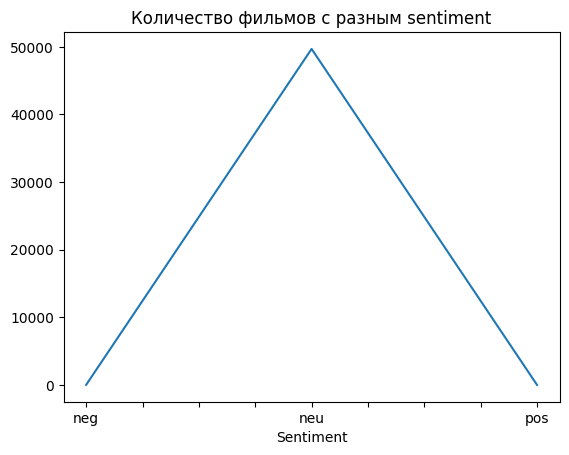

In [40]:
merged_dataset['Sentiment'] = sentiments
merged_dataset.head()
films_count_by_year = merged_dataset.groupby(['Sentiment'])['Title'].count()
films_count_by_year.plot(title = 'Количество фильмов с разным sentiment')
